In [42]:
from census import Census
import cenpy as c
import cenpy.tiger as tiger
from us import states
import pysal
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import my_api_key
import json
from shapely.geometry import Point
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
# Read two datasets into dataframes and concatenate into one dataset: crime_df

crime_17_df = pd.read_csv("data/chicago_crime_2017.csv")
crime_18_df = pd.read_csv("data/chicago_crime_2018.csv")
crime_df = pd.concat([crime_17_df, crime_18_df])
# Drop all rows with NAs in Latitude and Longitude
crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])

In [11]:
#Create a shapely dataframe using Latitude and Longitude of crime_df: crime_gdf
crime_df["Coordinates"] = list(zip(crime_df.Longitude, crime_df.Latitude))
crime_df["Coordinates"] = crime_df["Coordinates"].apply(Point)
crime_gdf = gpd.GeoDataFrame(crime_df, geometry='Coordinates')
crime_gdf = crime_gdf[["Date", "Block", "Primary Type", "Community Area", "Year", "Coordinates"]]

In [12]:
crime_gdf.head()

,Date,Block,Primary Type,Community Area,Year,Coordinates
0,09/21/2017 12:15:00 AM,072XX N CALIFORNIA AVE,DECEPTIVE PRACTICE,2.0,2017,POINT (-87.699714109 42.012293397)
1,10/12/2017 07:14:00 PM,055XX W GRAND AVE,CRIMINAL DAMAGE,19.0,2017,POINT (-87.76551062999999 41.918711651)
2,10/30/2017 11:52:00 AM,043XX S TALMAN AVE,OTHER OFFENSE,58.0,2017,POINT (-87.690726696 41.814669784)
3,09/29/2017 06:45:00 PM,055XX W BELMONT AVE,DECEPTIVE PRACTICE,19.0,2017,POINT (-87.765830579 41.938581442)
4,12/01/2017 06:20:00 AM,022XX W CHICAGO AVE,CRIM SEXUAL ASSAULT,24.0,2017,POINT (-87.683159355 41.895805099)


In [98]:
connection = Census(my_api_key.MY_API_KEY, year=2017)
acs_list = connection.acs5.state_county_blockgroup(("NAME", "GEO_ID", "B02001_001E", "B19013_001E"), '17', '031', Census.ALL)
# B02001_001E = race, B19013_001E = Median household income in the past 12 months
acs_json = json.dumps(acs_list)
acs_df = pd.read_json(acs_json).dropna()
acs_df.rename(columns={'B19013_001E':'Income'}, inplace=True)
acs_df = acs_df[acs_df.Income != -666666666]
acs_df['GEO_ID'] = acs_df['GEO_ID'].str.replace(r'1500000US', '')

CensusException: error: error: unknown variable 'S1101_C01_002E'

In [100]:
acs_df.head("B19013_001E")

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [B19013_001E] of <class 'str'>

In [16]:
#Create a dataframe to geographically connect acs_df and crime_gdf
conn = c.base.Connection('ACSDT5Y2011')
conn.set_mapservice("tigerWMS_ACS2017")
conn.mapservice
geodata = conn.mapservice.query(layer=10, where='STATE = 17')
geodata = geodata[["COUNTY", "GEOID", "NAME", "TRACT", "geometry"]]
geodata.rename(columns={'GEOID':'GEO_ID'}, inplace=True)

In [17]:
geodata.columns

Index(['COUNTY', 'GEO_ID', 'NAME', 'TRACT', 'geometry'], dtype='object')

In [25]:
geodata.head(100)

,COUNTY,GEO_ID,NAME,TRACT,geometry
0,031,170318091003,Block Group 3,809100,"POLYGON ((-9763920.5912 5169700.912799999, -97..."
1,031,170312315004,Block Group 4,231500,POLYGON ((-9764807.139599999 5145329.259800002...
2,031,170315703002,Block Group 2,570300,POLYGON ((-9765878.144400001 5131687.360299997...
3,031,170315703003,Block Group 3,570300,"POLYGON ((-9766164.2355 5132229.018799998, -97..."
4,031,170315704001,Block Group 1,570400,POLYGON ((-9765208.557700001 5132245.446699999...
5,031,170315704002,Block Group 2,570400,"POLYGON ((-9765338.5789 5131969.162199996, -97..."
6,031,170315705001,Block Group 1,570500,POLYGON ((-9766682.316400001 5131040.904799998...
7,193,171939584001,Block Group 1,958400,"POLYGON ((-9831720.1723 4584996.317100003, -98..."
8,197,171978835213,Block Group 3,883521,"POLYGON ((-9783797.7995 5090817.611000001, -97..."
9,031,170318148005,Block Group 5,814800,POLYGON ((-9774273.415200001 5138591.732000001...


In [64]:
#geodata = geodata.to_crs(crime_gdf.crs)
geodataWGS84 = geodata.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

crime_bg_df = gpd.sjoin(crime_gdf, geodataWGS84, how="right", op='within')

In [61]:
geodataWGS84.head()

,COUNTY,GEO_ID,NAME,TRACT,geometry
0,031,170318091003,Block Group 3,809100,POLYGON ((-87.71079100004273 42.05819599975842...
1,031,170312315004,Block Group 4,231500,POLYGON ((-87.71875499982106 41.89543699990416...
2,031,170315703002,Block Group 2,570300,"POLYGON ((-87.7283759996331 41.80415200002722,..."
3,031,170315703003,Block Group 3,570300,POLYGON ((-87.73094599971091 41.80777900026446...
4,031,170315704001,Block Group 1,570400,POLYGON ((-87.72236099996658 41.80788899994042...


In [72]:
crime_bg_df = crime_bg_df.reset_index()
crime_bg_df = crime_bg_df[["Date", "Block", "Primary Type", "Community Area", "Year", "GEO_ID", "geometry"]]
crime_bg_df = crime_bg_df.dropna()

In [84]:
full_crime_df = pd.merge(crime_bg_df, acs_df, on='GEO_ID', how='left')
full_crime_df.head()

,Date,Block,Primary Type,Community Area,Year,GEO_ID,geometry,B02001_001E,B19013_001E,NAME,block group,county,state,tract
0,09/11/2018 03:26:00 PM,007XX N MONTICELLO AVE,PUBLIC PEACE VIOLATION,23.0,2018.0,170312315004,POLYGON ((-87.71875499982106 41.89543699990416...,1060.0,28472.0,"Block Group 4, Census Tract 2315, Cook County,...",4.0,31.0,17.0,231500.0
1,09/01/2018 11:01:00 AM,007XX N CENTRAL PARK AVE,OTHER OFFENSE,23.0,2018.0,170312315004,POLYGON ((-87.71875499982106 41.89543699990416...,1060.0,28472.0,"Block Group 4, Census Tract 2315, Cook County,...",4.0,31.0,17.0,231500.0
2,01/04/2017 05:00:00 PM,007XX N CENTRAL PARK AVE,THEFT,23.0,2017.0,170312315004,POLYGON ((-87.71875499982106 41.89543699990416...,1060.0,28472.0,"Block Group 4, Census Tract 2315, Cook County,...",4.0,31.0,17.0,231500.0
3,09/12/2018 08:45:00 PM,007XX N CENTRAL PARK AVE,THEFT,23.0,2018.0,170312315004,POLYGON ((-87.71875499982106 41.89543699990416...,1060.0,28472.0,"Block Group 4, Census Tract 2315, Cook County,...",4.0,31.0,17.0,231500.0
4,03/17/2018 03:19:00 PM,036XX W CHICAGO AVE,NARCOTICS,23.0,2018.0,170312315004,POLYGON ((-87.71875499982106 41.89543699990416...,1060.0,28472.0,"Block Group 4, Census Tract 2315, Cook County,...",4.0,31.0,17.0,231500.0


In [91]:
full_crime_df["geometry"]

0         POLYGON ((-87.71875499982106 41.89543699990416...
1         POLYGON ((-87.71875499982106 41.89543699990416...
2         POLYGON ((-87.71875499982106 41.89543699990416...
3         POLYGON ((-87.71875499982106 41.89543699990416...
4         POLYGON ((-87.71875499982106 41.89543699990416...
5         POLYGON ((-87.71875499982106 41.89543699990416...
6         POLYGON ((-87.71875499982106 41.89543699990416...
7         POLYGON ((-87.71875499982106 41.89543699990416...
8         POLYGON ((-87.71875499982106 41.89543699990416...
9         POLYGON ((-87.71875499982106 41.89543699990416...
10        POLYGON ((-87.71875499982106 41.89543699990416...
11        POLYGON ((-87.71875499982106 41.89543699990416...
12        POLYGON ((-87.71875499982106 41.89543699990416...
13        POLYGON ((-87.71875499982106 41.89543699990416...
14        POLYGON ((-87.71875499982106 41.89543699990416...
15        POLYGON ((-87.71875499982106 41.89543699990416...
16        POLYGON ((-87.71875499982106 4

In [96]:
test_gdf.head()

,geometry,B19013_001E
0,POLYGON ((-87.71875499982106 41.89543699990416...,28472.0
1,POLYGON ((-87.71875499982106 41.89543699990416...,28472.0
2,POLYGON ((-87.71875499982106 41.89543699990416...,28472.0
3,POLYGON ((-87.71875499982106 41.89543699990416...,28472.0
4,POLYGON ((-87.71875499982106 41.89543699990416...,28472.0


Text(0.5, 1.0, 'Alameda County, CA - Median Household Income by Census Tract')

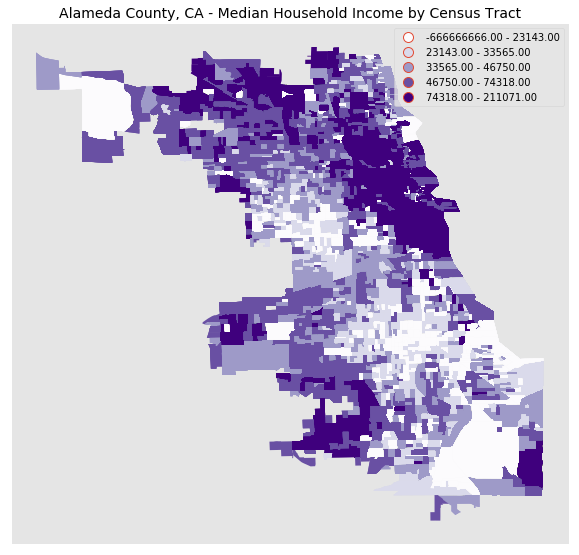

In [97]:
test = full_crime_df[["geometry", "B19013_001E"]].dropna()
test_gdf = gpd.GeoDataFrame(test, geometry='geometry')
fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal', xticks=[], yticks=[])
test_gdf.plot(column= "B19013_001E", ax = ax, scheme='quantiles', cmap='Purples', legend=True)
plt.title('Alameda County, CA - Median Household Income by Census Tract', size = 14)